In [106]:
from math import nan
from re import compile

from numpy import arange, array_equal
from pandas import read_csv, DataFrame, concat, Series, isna
from pingouin import ttest
from seaborn import lineplot, FacetGrid, set_theme, scatterplot

In [2]:
measures = DataFrame([
    {"name": "nDCG@5 rel.", "display_name": r"nDCG@5 relevance", "maximize": True, },
    {"name": "nDCG@5 qual.", "display_name": r"nDCG@5 quality", "maximize": True, },
])
measures

,name,display_name,maximize
0,nDCG@5 rel.,nDCG@5 relevance,True
1,nDCG@5 qual.,nDCG@5 quality,True


In [3]:
def target_f1(name: str) -> float:
    parts = name.split(" + ")
    for part in parts:
        if part.startswith("randomize"):
            match = compile(r"randomize\(F1<=(.*)\)").match(part)
            if not match:
                return 1.0
            return float(match.group(1))
    if "ground-truth" in parts:
        return 1.0
    return nan

In [4]:
df: DataFrame = read_csv("../data/metrics-reranking.csv")

# Remove duplicate runs.
# df = df.groupby(["name", "qid"], dropna=False, sort=False).aggregate("first").reset_index()

# Pivot measures into column values.
df = concat([
    concat([
        df[["name", "qid", measure]].rename(columns={measure: "value"}),
        DataFrame({"measure": [measure] * len(df)}),
    ], axis=1)
    for measure in measures["name"]
])

# Add run/team/reranker names.
df["run"] = df["name"].apply(lambda name: name.split(" + ", maxsplit=1)[0])
df["team"] = df["run"].apply(lambda run: run.split(" ", maxsplit=1)[0])
df["reranker"] = [
    name.split(" + ", maxsplit=1)[1] if name != run else nan
    for _, (name, run) in df[["name", "run"]].iterrows()
]

# Detect target F1 scores.
df["target_f1"] = df["name"].apply(target_f1)

# Select columns.
df = df[["name", "team", "run", "reranker", "target_f1", "qid", "measure", "value"]]

# Compute aggregated metric values.
df_aggregated = df[["name", "measure", "qid", "value"]].groupby(["name", "measure"], dropna=False,
                                                                sort=False).aggregate("mean").drop(
    columns=["qid"])
df = df.merge(df_aggregated, on=["name", "measure"], suffixes=("", "_aggregated"))

# Add differences to original runs.
df = df.merge(
    df.loc[df["reranker"].isna(), ["qid", "measure", "run", "value", "value_aggregated"]],
    on=["qid", "measure", "run"],
    suffixes=("", "_original"),
).rename(columns={"value_aggregated_original": "value_original_aggregated"})

# Add differences to optimal runs.
df = df.merge(
    df.loc[df["reranker"] == "optimal-relevance@5", ["qid", "measure", "run", "value", "value_aggregated"]],
    on=["qid", "measure", "run"],
    suffixes=("", "_optimal_relevance"),
)
# df = df[df["reranker"] != "optimal-relevance@5"]
df = df.merge(
    df.loc[df["reranker"] == "optimal-quality@5", ["qid", "measure", "run", "value", "value_aggregated"]],
    on=["qid", "measure", "run"],
    suffixes=("", "_optimal_quality"),
)
# df = df[df["reranker"] != "optimal-quality@5"]
df.loc[df["measure"] == "nDCG@5 rel.", "value_optimal"] = df.loc[
    df["measure"] == "nDCG@5 rel.", "value_optimal_relevance"]
df.loc[df["measure"] == "nDCG@5 rel.", "value_optimal_aggregated"] = df.loc[
    df["measure"] == "nDCG@5 rel.", "value_aggregated_optimal_relevance"]
del df["value_optimal_relevance"]
del df["value_aggregated_optimal_relevance"]
df.loc[df["measure"] == "nDCG@5 qual.", "value_optimal"] = df.loc[
    df["measure"] == "nDCG@5 qual.", "value_optimal_quality"]
df.loc[df["measure"] == "nDCG@5 qual.", "value_optimal_aggregated"] = df.loc[
    df["measure"] == "nDCG@5 qual.", "value_aggregated_optimal_quality"]
del df["value_optimal_quality"]
del df["value_aggregated_optimal_quality"]
df

,name,team,run,reranker,target_f1,qid,measure,value,value_aggregated,value_original,value_original_aggregated,value_optimal,value_optimal_aggregated
0,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,NaN,NaN,100,nDCG@5 rel.,0.170,0.54662,0.170,0.54662,0.339,0.60660
1,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-relevance@5,NaN,100,nDCG@5 rel.,0.339,0.60660,0.170,0.54662,0.339,0.60660
2,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-quality@5,NaN,100,nDCG@5 rel.,0.339,0.56770,0.170,0.54662,0.339,0.60660
3,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,ground-truth + stance-first@5,1.0,100,nDCG@5 rel.,0.339,0.57594,0.170,0.54662,0.339,0.60660
4,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,stance-first@5,NaN,100,nDCG@5 rel.,0.170,0.54642,0.170,0.54662,0.339,0.60660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436795,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.20)@5 + stance-...,0.2,95,nDCG@5 qual.,0.308,0.46722,0.361,0.47622,0.361,0.54428
436796,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.20)@5 + stance-...,0.2,95,nDCG@5 qual.,0.308,0.46722,0.361,0.47622,0.361,0.54428
436797,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.20)@5 + stance-...,0.2,95,nDCG@5 qual.,0.308,0.46722,0.361,0.47622,0.361,0.54428
436798,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.20)@5 + stance-...,0.2,95,nDCG@5 qual.,0.308,0.46722,0.361,0.47622,0.361,0.54428


In [5]:
df[df["value_original"] != df["value_optimal"]]

,name,team,run,reranker,target_f1,qid,measure,value,value_aggregated,value_original,value_original_aggregated,value_optimal,value_optimal_aggregated
0,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,NaN,NaN,100,nDCG@5 rel.,0.170,0.54662,0.170,0.54662,0.339,0.60660
1,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-relevance@5,NaN,100,nDCG@5 rel.,0.339,0.60660,0.170,0.54662,0.339,0.60660
2,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-quality@5,NaN,100,nDCG@5 rel.,0.339,0.56770,0.170,0.54662,0.339,0.60660
3,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,ground-truth + stance-first@5,1.0,100,nDCG@5 rel.,0.339,0.57594,0.170,0.54662,0.339,0.60660
4,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,stance-first@5,NaN,100,nDCG@5 rel.,0.170,0.54642,0.170,0.54662,0.339,0.60660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436459,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.20)@5 + stance-...,0.2,92,nDCG@5 qual.,0.322,0.46722,0.503,0.47622,0.592,0.54428
436460,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.20)@5 + stance-...,0.2,92,nDCG@5 qual.,0.322,0.46722,0.503,0.47622,0.592,0.54428
436461,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.20)@5 + stance-...,0.2,92,nDCG@5 qual.,0.322,0.46722,0.503,0.47622,0.592,0.54428
436462,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.20)@5 + stance-...,0.2,92,nDCG@5 qual.,0.322,0.46722,0.503,0.47622,0.592,0.54428


In [6]:
short_team_names = {}
team: str
for team in df["team"].sort_values().unique():
    orig_team = team
    for prefix in ["Captain", "Olivier", "Puss-in"]:
        if team.startswith(prefix):
            team = prefix + team.removeprefix(prefix)[:2] + "."
    short_team_names[orig_team] = team.replace("-", " ")
short_team_names

{'Aldo-Nadi': 'Aldo Nadi',
 'Asuna': 'Asuna',
 'Captain-Levi': 'Captain L.',
 'Captain-Tempesta': 'Captain T.',
 'Grimjack': 'Grimjack',
 'Katana': 'Katana',
 'Olivier-Armstrong': 'Olivier A.',
 'Puss-in-Boots': 'Puss in B.'}

In [7]:
short_run_names = {}
for team in df["team"].unique():
    for run, char in zip(df[df["team"] == team]["run"].sort_values().unique(), "ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
        short_run_names[(team, run)] = char
short_run_names

{('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_RF_reranked'): 'A',
 ('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_false_porter'): 'B',
 ('Aldo-Nadi',
  'Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_false_porter_reranked'): 'C',
 ('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_rrf'): 'D',
 ('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_rrf_reranked'): 'E',
 ('Asuna', 'Asuna asuna-run-5'): 'A',
 ('Captain-Levi', 'Captain-Levi levirank_baseline_large_duo_t5'): 'A',
 ('Captain-Levi', 'Captain-Levi levirank_dense_initial_retrieval'): 'B',
 ('Captain-Levi', 'Captain-Levi levirank_psuedo_relevance_feedback'): 'C',
 ('Captain-Levi',
  'Captain-Levi levirank_psuedo_relevance_feedback+voting'): 'D',
 ('Captain-Levi', 'Captain-Levi levirank_voting_retrieval'): 'E',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_1'): 'A',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_2'): 'B',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_3'): 'C',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_4'): 'D

In [8]:
print(r"\begin{tabular}{@{}lll@{}}")
print(r"    \toprule")
print(r"    \multicolumn{2}{@{}l}{Run} & Run ID \\")
print(r"    \midrule")
for team in df["team"].sort_values().unique():
    for run in df[df["team"] == team]["run"].sort_values().unique():
        print(f"    {team.replace('-', ' ')} & {short_run_names[(team, run)]} & {run.removeprefix(team)[1:]} \\\\")
print(r"    \bottomrule")
print(r"\end{tabular}")

\begin{tabular}{@{}lll@{}}
    \toprule
    \multicolumn{2}{@{}l}{Run} & Run ID \\
    \midrule
    Aldo Nadi & A & seupd2122-kueri_RF_reranked \\
    Aldo Nadi & B & seupd2122-kueri_kueristopv2_BM2_false_porter \\
    Aldo Nadi & C & seupd2122-kueri_kueristopv2_BM2_false_porter_reranked \\
    Aldo Nadi & D & seupd2122-kueri_rrf \\
    Aldo Nadi & E & seupd2122-kueri_rrf_reranked \\
    Asuna & A & asuna-run-5 \\
    Captain Levi & A & levirank_baseline_large_duo_t5 \\
    Captain Levi & B & levirank_dense_initial_retrieval \\
    Captain Levi & C & levirank_psuedo_relevance_feedback \\
    Captain Levi & D & levirank_psuedo_relevance_feedback+voting \\
    Captain Levi & E & levirank_voting_retrieval \\
    Captain Tempesta & A & hextech_run_1 \\
    Captain Tempesta & B & hextech_run_2 \\
    Captain Tempesta & C & hextech_run_3 \\
    Captain Tempesta & D & hextech_run_4 \\
    Captain Tempesta & E & hextech_run_5 \\
    Grimjack & A & grimjack-all-you-need-is-t0 \\
    Grimjack & 

In [9]:
rerankers_table = {
    nan: r"Touch{\'e}",
    "ground-truth + stance-first@5": r"Oracle~{\tiny(\fone\tinymathsymbol{\bm{=}}1.00)}",
    "ground-truth + randomize(F1<=0.75)@5 + stance-first@5": r"Simul.~{\tiny(\fone\tinymathsymbol{\bm{\approx}}0.75)}",
    "gpt3-tsv + stance-first@5": r"GPT-3~{\tiny(\fone\tinymathsymbol{\bm{=}}0.49)}",
    "google/flan-t5-base@5 + stance-first@5": r"Flan-T5~{\tiny(\fone\tinymathsymbol{\bm{=}}0.39)}",
    "roberta-csv + stance-first@5": r"\kern-0.25em RoBERTa~{\tiny(\fone\tinymathsymbol{\bm{=}}0.34)}\kern-0.25em",
    "stance-first@5": r"Orig.~{\tiny(\fone\tinymathsymbol{\bm{\leq}}0.31)}",
}
correction_n = len(rerankers_table) + 1

for key in rerankers_table.keys():
    if (not isna(key) and len(df[df["reranker"] == key]) == 0) or (isna(key) and len(df[df["reranker"].isna()]) == 0):
        raise ValueError(f"Re-ranker '{key}' not found.")

In [10]:
df_table = df[
    df["reranker"].isin(rerankers_table.keys()) |
    df["reranker"].isna()
    ]
reranker_index = {
    reranker: i
    for i, reranker in enumerate(rerankers_table.keys())
}


def table_row(df: DataFrame, measure_name: str, run: str, reranker: str) -> Series:
    measure = measures[measures["name"] == measure_name].iloc[0]

    df_reranked = df[df["run"] == run]
    if isna(reranker):
        df_reranked = df_reranked[df_reranked["reranker"].isna()]
    else:
        df_reranked = df_reranked[df_reranked["reranker"] == reranker]

    df_reranked = df_reranked.groupby("qid", dropna=False, sort=False).aggregate({
        column: "mean" if column.startswith("value") else "first"
        for column in df_reranked.columns
        if column != "qid"
    }).reset_index()

    df_originals = df[df["reranker"].isna()].sort_values("run").sort_values("value_aggregated",
                                                                            ascending=not measure["maximize"])
    run_ranks_original = {run: i + 1 for i, run in enumerate(df_originals["run"].unique())}
    run_rank_original = run_ranks_original[run]
    df_leaderboard = concat([
        df_originals[df_originals["run"] != run],
        df_reranked,
    ])
    df_leaderboard = df_leaderboard.sort_values("run").sort_values("value_aggregated",
                                                                   ascending=not measure["maximize"])
    run_ranks = {run: i + 1 for i, run in enumerate(df_leaderboard["run"].unique())}
    run_rank = run_ranks[run]

    df_original = df_originals[df_originals["run"] == run]

    df_reranked = df_reranked.sort_values("qid")
    df_original = df_original.sort_values("qid")

    if not array_equal(df_original["value"], df_reranked["value"]):
        stats = ttest(df_original["value"], df_reranked["value"], paired=True)
    else:
        stats = DataFrame({
            "p-val": [nan],
            "CI95%": [(nan, nan)],
            "cohen-d": [nan],
        })

    res: Series = df_reranked[[
        "name", "team", "run", "reranker", "measure",
        "value_aggregated", "value_original_aggregated", "value_optimal_aggregated"
    ]].iloc[0]
    res["run_rank"] = run_rank
    res["run_rank_original"] = run_rank_original
    res["reranker_index"] = reranker_index[reranker]
    res["p_value"] = stats["p-val"].iloc[0]
    res["p_value_corrected"] = stats["p-val"].iloc[0] * correction_n
    res["ci95_low"] = stats["CI95%"].iloc[0][0]
    res["ci95_high"] = stats["CI95%"].iloc[0][1]
    res["cohen_d"] = stats["cohen-d"].iloc[0]
    return res


df_table = DataFrame([
    table_row(
        df_table_measure,
        measure,
        run,
        reranker,
    )
    for reranker in rerankers_table.keys()
    for measure, df_table_measure in df_table.groupby("measure", dropna=False, sort=False)
    for run in df_table["run"].unique()
])

df_table.sort_values(["measure", "reranker_index", "run_rank"], ascending=[False, True, True], inplace=True)

df_table

,name,team,run,reranker,measure,value_aggregated,value_original_aggregated,value_optimal_aggregated,run_rank,run_rank_original,reranker_index,p_value,p_value_corrected,ci95_low,ci95_high,cohen_d
6,Captain-Levi levirank_dense_initial_retrieval,Captain-Levi,Captain-Levi levirank_dense_initial_retrieval,None,nDCG@5 rel.,0.75772,0.75772,0.81460,1,1,0,NaN,NaN,NaN,NaN,NaN
6,Captain-Levi levirank_baseline_large_duo_t5,Captain-Levi,Captain-Levi levirank_baseline_large_duo_t5,None,nDCG@5 rel.,0.75512,0.75512,0.81528,2,2,0,NaN,NaN,NaN,NaN,NaN
6,Captain-Levi levirank_psuedo_relevance_feedbac...,Captain-Levi,Captain-Levi levirank_psuedo_relevance_feedbac...,None,nDCG@5 rel.,0.75280,0.75280,0.81268,3,3,0,NaN,NaN,NaN,NaN,NaN
6,Captain-Levi levirank_voting_retrieval,Captain-Levi,Captain-Levi levirank_voting_retrieval,None,nDCG@5 rel.,0.72734,0.72734,0.79032,4,4,0,NaN,NaN,NaN,NaN,NaN
6,Captain-Levi levirank_psuedo_relevance_feedback,Captain-Levi,Captain-Levi levirank_psuedo_relevance_feedback,None,nDCG@5 rel.,0.72146,0.72146,0.78258,5,5,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,Grimjack grimjack-fair-argumentative-reranking...,Grimjack,Grimjack grimjack-fair-argumentative-reranking...,stance-first@5,nDCG@5 qual.,0.36526,0.36526,0.42194,22,22,6,NaN,NaN,NaN,NaN,NaN
6,Grimjack grimjack-baseline + stance-first@5,Grimjack,Grimjack grimjack-baseline,stance-first@5,nDCG@5 qual.,0.36342,0.36342,0.44190,23,23,6,NaN,NaN,NaN,NaN,NaN
6,Grimjack grimjack-argumentative-axioms + stanc...,Grimjack,Grimjack grimjack-argumentative-axioms,stance-first@5,nDCG@5 qual.,0.36342,0.36342,0.44190,24,24,6,NaN,NaN,NaN,NaN,NaN
6,Grimjack grimjack-all-you-need-is-t0 + stance-...,Grimjack,Grimjack grimjack-all-you-need-is-t0,stance-first@5,nDCG@5 qual.,0.34436,0.34436,0.41780,25,25,6,NaN,NaN,NaN,NaN,NaN


In [11]:
small_sep_factor = 0.75
extra_sep_factor = 3
parts = ["l", r"@{\hspace{" + f"{small_sep_factor}" + r"\tabcolsep}}", "l"]
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    parts.append(r"@{\hspace{" + f"{extra_sep_factor}" + r"\tabcolsep}}")
    if isna(reranker):
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{small_sep_factor}" + r"\tabcolsep}}")
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{extra_sep_factor}" + r"\tabcolsep}}")
        parts.append("r")
    else:
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{small_sep_factor}" + r"\tabcolsep}}")
        parts.append("r")
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{small_sep_factor}" + r"\tabcolsep}}")
        parts.append("r")
print(r"\begin{tabular}{@{}" + "".join(parts) + r"@{}}")
print(r"    \toprule")

parts = [r"\multicolumn{2}{@{}l}{\textbf{Run}}"]
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    space = "\hspace{" + f"{extra_sep_factor}" + r"\tabcolsep}" if i < len(rerankers_table) - 1 else ""
    if isna(reranker):
        reranker = rerankers_table[nan]
        parts.append("\multicolumn{2}{@{}c@{" + space + r"}}{\textbf{" + reranker + r"}}")
        parts.append("\multicolumn{1}{@{}c@{" + space + r"}}{\textbf{Opt.}}")
    else:
        reranker = rerankers_table[reranker]
        parts.append(r"\multicolumn{4}{@{}c@{" + space + r"}}{\textbf{" + reranker + r"}}")
print("    " + " & ".join(parts) + r" \\")

parts = []
col = 3
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    space = "r{" + f"{extra_sep_factor}" + r"\tabcolsep}" if i < len(rerankers_table) - 1 else ""
    if isna(reranker):
        parts.append("\cmidrule(" + space + "){" + str(col) + "-" + str(col + 1) + "}")
        col += 2
        parts.append("\cmidrule(" + space + "){" + str(col) + "-" + str(col) + "}")
        col += 1
    else:
        parts.append("\cmidrule(" + space + "){" + str(col) + "-" + str(col + 3) + "}")
        col += 4
print("    " + "".join(parts))

parts = ["", ""]
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    space = "\hspace{" + f"{extra_sep_factor}" + r"\tabcolsep}" if i < len(rerankers_table) - 1 else ""
    if isna(reranker):
        parts.append(r"\multicolumn{1}{@{}l}{Score\kern-1em}")
        parts.append(r"\#")
        parts.append(r"\kern-0.1emScore\kern-0.1em")
    else:
        parts.append(r"\multicolumn{1}{@{}l}{Score\kern-1em}")
        parts.append(r"\multicolumn{1}{c}{\tiny$\Delta$}")
        parts.append(r"\#")
        parts.append(r"\multicolumn{1}{c}{\tiny$\Delta$}")
print("    " + " & ".join(parts) + r" \\")
print(r"    \midrule")

for i, (measure_name, df_measure) in enumerate(df_table.groupby("measure", dropna=False, sort=False)):
    measure = measures[measures["name"] == measure_name].iloc[0]
    measure_display_name = measure["display_name"]
    if measure_display_name == "nDCG@5 relevance":
        measure_display_name = r"Topical relevance"
        perfect_column = "optimal_relevance"
    elif measure_display_name == "nDCG@5 quality":
        measure_display_name = r"Argument quality"
        perfect_column = "optimal_quality"
    df_measure = df_measure.sort_values("run_rank_original")
    if i > 0:
        print(r"    \midrule")
    print(r"    \multicolumn{" + str(len(parts)) + r"}{@{}l@{}}{\textit{" + measure_display_name + r"}} \\")
    print(r"    \midrule")
    for (team, run), df_run in df_measure.groupby(["team", "run"], dropna=False, sort=False):
        df_run = df_run.sort_values("reranker_index")
        short_team = short_team_names[team]
        short_run = short_run_names[(team, run)]
        short_team = short_team.replace("_", r"\_")
        short_run = short_run.replace("_", r"\_")
        parts = [short_team, short_run]
        for reranker, df_reranker in df_run.groupby("reranker", dropna=False, sort=False):
            hidden = (not isna(reranker) and "Orig" in rerankers_table[reranker] and
                      df_reranker["team"].iloc[0] in ("Aldo-Nadi", "Captain-Tempesta"))
            value_aggregated = df_reranker["value_aggregated"].iloc[0]
            value_original_aggregated = df_reranker["value_original_aggregated"].iloc[0]
            value_optimal_aggregated = df_reranker[f"value_optimal_aggregated"].iloc[0]
            if hidden:
                value_aggregated = value_original_aggregated
            difference_original_aggregated = value_aggregated.round(2) - value_original_aggregated.round(2)
            run_rank = df_reranker["run_rank"].iloc[0]
            run_rank_original = df_reranker["run_rank_original"].iloc[0]
            if hidden:
                run_rank = run_rank_original
            run_rank_difference = run_rank - run_rank_original
            sub_parts = []
            if isna(reranker):
                sub_parts.append(f"{value_aggregated:.2f}")
                sub_parts.append(f"{run_rank_original:.0f}")
                sub_parts.append(f"{value_optimal_aggregated:.2f}")
            else:
                val_str = f"{value_aggregated:.2f}"
                if df_reranker["p_value_corrected"].iloc[0] < 0.05:
                    val_str = r"\significant{" + val_str + r"}"
                sub_parts.append(val_str)
                if difference_original_aggregated > 0:
                    diff_str = r"\scorediffgt{" + f"{abs(difference_original_aggregated):.2f}" + r"}"
                elif difference_original_aggregated < 0:
                    diff_str = r"\scoredifflt{" + f"{abs(difference_original_aggregated):.2f}" + r"}"
                else:
                    diff_str = r"\scorediffeq{" + f"{abs(difference_original_aggregated):.2f}" + r"}"
                sub_parts.append(diff_str)
                rank_str = f"{run_rank:.0f}"
                sub_parts.append(rank_str)
                if run_rank_difference > 0:
                    rank_diff_str = r"\rankdiffgt{" + f"{abs(run_rank_difference)}" + r"}"
                elif run_rank_difference < 0:
                    rank_diff_str = r"\rankdifflt{" + f"{abs(run_rank_difference)}" + r"}"
                else:
                    rank_diff_str = r"\rankdiffeq{" + f"{abs(run_rank_difference)}" + r"}"
                sub_parts.append(rank_diff_str)
                if hidden:
                    sub_parts = [
                        r"\hidden{" + part + r"}"
                        for part in sub_parts
                    ]
            parts += sub_parts
        print("    " + " & ".join(parts) + r" \\")

print(r"    \bottomrule")
print(r"\end{tabular}")

\begin{tabular}{@{}l@{\hspace{0.75\tabcolsep}}l@{\hspace{3\tabcolsep}}r@{\hspace{0.75\tabcolsep}}r@{\hspace{3\tabcolsep}}r@{\hspace{3\tabcolsep}}r@{\hspace{0.75\tabcolsep}}rr@{\hspace{0.75\tabcolsep}}r@{\hspace{3\tabcolsep}}r@{\hspace{0.75\tabcolsep}}rr@{\hspace{0.75\tabcolsep}}r@{\hspace{3\tabcolsep}}r@{\hspace{0.75\tabcolsep}}rr@{\hspace{0.75\tabcolsep}}r@{\hspace{3\tabcolsep}}r@{\hspace{0.75\tabcolsep}}rr@{\hspace{0.75\tabcolsep}}r@{\hspace{3\tabcolsep}}r@{\hspace{0.75\tabcolsep}}rr@{\hspace{0.75\tabcolsep}}r@{\hspace{3\tabcolsep}}r@{\hspace{0.75\tabcolsep}}rr@{\hspace{0.75\tabcolsep}}r@{}}
    \toprule
    \multicolumn{2}{@{}l}{\textbf{Run}} & \multicolumn{2}{@{}c@{\hspace{3\tabcolsep}}}{\textbf{Touch{\'e}}} & \multicolumn{1}{@{}c@{\hspace{3\tabcolsep}}}{\textbf{Opt.}} & \multicolumn{4}{@{}c@{\hspace{3\tabcolsep}}}{\textbf{Oracle~{\tiny(\fone\tinymathsymbol{\bm{=}}1.00)}}} & \multicolumn{4}{@{}c@{\hspace{3\tabcolsep}}}{\textbf{Simul.~{\tiny(\fone\tinymathsymbol{\bm{\approx}}0.75)}}

In [12]:
first_bin = 0.25
last_bin = 1.00
bin_step = 0.05
bins = list(arange(
    first_bin - (bin_step / 2),
    last_bin + (bin_step / 2) + 0.0001,
    bin_step,
))
# bins

In [13]:
difference_data = []
df_tmp = df.copy()
df_tmp = df_tmp[~df_tmp["target_f1"].isna()]
df_tmp["difference_original"] = df_tmp["value"] - df_tmp["value_original"]
for (measure_name, team), df_team in df_tmp.groupby(["measure", "team"], sort=False):
    measure = measures[measures["name"] == measure_name].iloc[0]
    run = df_team.sort_values("value_original_aggregated", ascending=not measure["maximize"])["run"].iloc[0]
    df_run = df_team[df_team["run"] == run]
    for (target_f1, qid, run), df_group in df_run.groupby(["target_f1", "qid", "run"]):
        difference_data.append({
            "team": team,
            "run": run,
            "target_f1": target_f1,
            "measure": measure["display_name"],
            "qid": qid,
            "value": df_group["value"].mean(),
            "difference": df_group["difference_original"].mean(),
        })
df_plot = DataFrame(difference_data)
df_plot["team"] = df_plot["team"].map(short_team_names)
df_plot = df_plot[df_plot["target_f1"] >= first_bin]
df_plot

,team,run,target_f1,measure,qid,value,difference
50,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,2,0.842,0.034
51,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,3,0.746,-0.081
52,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,8,1.000,0.000
53,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,9,0.216,-0.123
54,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,12,0.842,0.022
...,...,...,...,...,...,...,...
13595,Puss in B.,Puss-in-Boots BM25-Baseline,1.00,nDCG@5 quality,91,0.446,0.000
13596,Puss in B.,Puss-in-Boots BM25-Baseline,1.00,nDCG@5 quality,92,0.592,0.089
13597,Puss in B.,Puss-in-Boots BM25-Baseline,1.00,nDCG@5 quality,93,1.000,0.000
13598,Puss in B.,Puss-in-Boots BM25-Baseline,1.00,nDCG@5 quality,95,0.361,0.000


In [14]:
set_theme(
    style="ticks",
    palette="colorblind",
    font_scale=1.0,
    font="sans-serif",
)

/home/heinrich/Repositories/stare/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


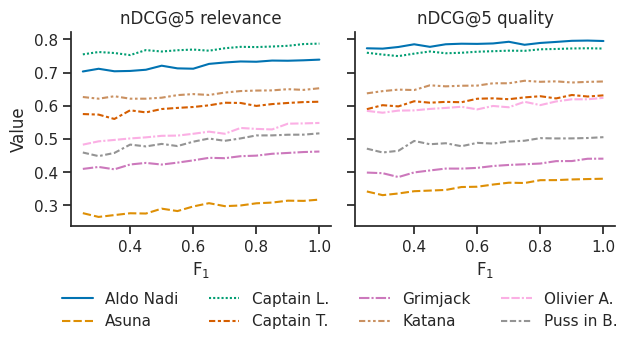

In [15]:
aspect = 1.15
width = 3.5
plot_values = FacetGrid(
    data=df_plot,
    col="measure",
    sharex=True,
    sharey=True,
    height=width / aspect,
    aspect=aspect,
)
plot_values.map_dataframe(
    lineplot,
    x="target_f1",
    y="value",
    hue="team",
    hue_order=df_plot["team"].sort_values().unique(),
    style="team",
    err_style=None,
)
plot_values.set_xlabels(r"F$_1$")
plot_values.set_ylabels(r"Value")
plot_values.add_legend(
    loc="upper left",
    ncols=4,
    bbox_to_anchor=(0.095, 0.06),
)
plot_values.set_titles(col_template="{col_name}")
plot_values.savefig("../data/plot-reranking-f1.pdf", transparent=True)
plot_values.savefig("../data/plot-reranking-f1.png")
plot_values

/home/heinrich/Repositories/stare/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/heinrich/Repositories/stare/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


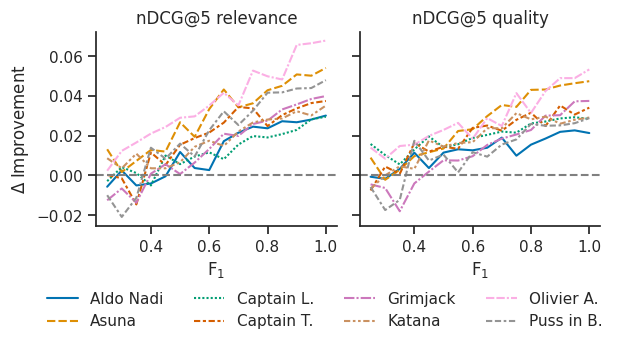

In [16]:
aspect = 1.15
width = 3.5
plot_differences = FacetGrid(
    data=df_plot,
    col="measure",
    sharex=True,
    sharey=True,
    height=width / aspect,
    aspect=aspect,
)
plot_differences.map_dataframe(
    lineplot,
    x="target_f1",
    y="difference",
    hue="team",
    hue_order=df_plot["team"].sort_values().unique(),
    style="team",
    err_style=None,
)
plot_differences.refline(y=0, color="gray")
plot_differences.set_xlabels(r"F$_1$")
plot_differences.set_ylabels(r"$\Delta$ Improvement")
plot_differences.add_legend(
    loc="upper left",
    ncols=4,
    bbox_to_anchor=(0.095, 0.06),
)
plot_differences.set_titles(col_template="{col_name}")
plot_differences.savefig("../data/plot-reranking-f1-difference.pdf", transparent=True)
plot_differences.savefig("../data/plot-reranking-f1-difference.png")
plot_differences

In [17]:
for measure_name, df_measure in df_tmp.groupby("measure", sort=False):
    measure = measures[measures["name"] == measure_name].iloc[0]
    run = df_measure.sort_values("value_original_aggregated", ascending=not measure["maximize"])["run"].iloc[0]
    df_measure = df_measure[df_measure["run"] == run]
    df_measure = df_measure[df_measure["target_f1"].notna()]
    for target_f1, df_target_f1 in df_measure.groupby("target_f1", sort=True):
        df_target_f1 = df_target_f1.groupby("qid", dropna=False, sort=False).aggregate({
            column: "mean" if column.startswith("value") else "first"
            for column in df_target_f1.columns
            if column != "qid"
        }).reset_index()
        values = df_target_f1["value"]
        values_original = df_target_f1["value_original"]

        if not array_equal(values_original, values):
            stats = ttest(values_original, values, paired=True)
        else:
            stats = DataFrame({
                "p-val": [nan],
                "CI95%": [(nan, nan)],
                "cohen-d": [nan],
            })
        p_val = stats["p-val"].iloc[0] * correction_n
        cohen_d = stats["cohen-d"].iloc[0]
        significant = p_val < 0.05 and values.mean() > values_original.mean()
        if significant:
            print(f"{measure_name} @ {target_f1:.2f}:", significant, f"{p_val:.2f}", f"{cohen_d:.1f}")
            break


nDCG@5 rel. @ 0.90: True 0.04 0.1


In [18]:
for measure_name, df_measure in df_tmp.groupby("measure", sort=False):
    measure = measures[measures["name"] == measure_name].iloc[0]
    df_measure = df_measure[df_measure["target_f1"].notna()]
    for target_f1, df_target_f1 in df_measure.groupby("target_f1", sort=True):
        num_improved = 0
        num_significant = 0
        num_runs = df_target_f1["run"].nunique()
        for run, df_run in df_target_f1.groupby("run", sort=False):
            df_run = df_run.groupby("qid", dropna=False, sort=False).aggregate({
                column: "mean" if column.startswith("value") else "first"
                for column in df_run.columns
                if column != "qid"
            }).reset_index()
            values = df_run["value"]
            values_original = df_run["value_original"]
            improved = values.mean() > values_original.mean() if measure[
                "maximize"] else values.mean() < values_original.mean()
            if improved:
                num_improved += 1

            if not array_equal(values_original, values):
                stats = ttest(values_original, values, paired=True)
            else:
                stats = DataFrame({
                    "p-val": [nan],
                    "CI95%": [(nan, nan)],
                    "cohen-d": [nan],
                })
            p_val = stats["p-val"].iloc[0] * correction_n
            cohen_d = stats["cohen-d"].iloc[0]
            significant = p_val < 0.05 and improved
            if significant:
                num_significant += 1
        print(f"{measure_name} @ {target_f1:.2f}:",
              # num_improved, num_runs, f"{num_improved/num_runs:.2f}", 
              num_significant, num_runs, f"{num_significant / num_runs:.2f}")


nDCG@5 rel. @ 0.20: 0 26 0.00
nDCG@5 rel. @ 0.25: 0 26 0.00
nDCG@5 rel. @ 0.30: 0 26 0.00
nDCG@5 rel. @ 0.35: 0 26 0.00
nDCG@5 rel. @ 0.40: 0 26 0.00
nDCG@5 rel. @ 0.45: 0 26 0.00
nDCG@5 rel. @ 0.50: 3 26 0.12
nDCG@5 rel. @ 0.55: 2 26 0.08
nDCG@5 rel. @ 0.60: 3 26 0.12
nDCG@5 rel. @ 0.65: 10 26 0.38
nDCG@5 rel. @ 0.70: 14 26 0.54
nDCG@5 rel. @ 0.75: 14 26 0.54
nDCG@5 rel. @ 0.80: 18 26 0.69
nDCG@5 rel. @ 0.85: 21 26 0.81
nDCG@5 rel. @ 0.90: 22 26 0.85
nDCG@5 rel. @ 0.95: 26 26 1.00
nDCG@5 rel. @ 1.00: 26 26 1.00
nDCG@5 qual. @ 0.20: 1 26 0.04
nDCG@5 qual. @ 0.25: 0 26 0.00
nDCG@5 qual. @ 0.30: 0 26 0.00
nDCG@5 qual. @ 0.35: 0 26 0.00
nDCG@5 qual. @ 0.40: 0 26 0.00
nDCG@5 qual. @ 0.45: 1 26 0.04
nDCG@5 qual. @ 0.50: 0 26 0.00
nDCG@5 qual. @ 0.55: 4 26 0.15
nDCG@5 qual. @ 0.60: 2 26 0.08
nDCG@5 qual. @ 0.65: 9 26 0.35
nDCG@5 qual. @ 0.70: 8 26 0.31
nDCG@5 qual. @ 0.75: 14 26 0.54
nDCG@5 qual. @ 0.80: 17 26 0.65
nDCG@5 qual. @ 0.85: 20 26 0.77
nDCG@5 qual. @ 0.90: 22 26 0.85
nDCG@5 qual. 

In [70]:
df_ranks = df.copy()
df_ranks = df_ranks.groupby(["measure", "name"], dropna=False, sort=False).first().reset_index()
df_ranks.drop(columns=["value", "value_original", "value_optimal", "team"], inplace=True)
df_ranks = df_ranks.merge(measures, left_on="measure", right_on="name", suffixes=("", "_measure"))

def table_row(df: DataFrame, maximize: bool, run: str, target_f1: float) -> Series:

    df_reranked = df[df["run"] == run]
    if isna(target_f1):
        df_reranked = df_reranked[df_reranked["target_f1"].isna()]
    else:
        df_reranked = df_reranked[df_reranked["target_f1"] == target_f1]

    df_reranked = df_reranked.groupby("qid", dropna=False, sort=False).aggregate({
        column: "mean" if column.startswith("value") else "first"
        for column in df_reranked.columns
        if column != "qid"
    }).reset_index()

    df_originals = df[df["reranker"].isna()].sort_values("run").sort_values("value_aggregated", ascending=not maximize)
    run_ranks_original = {run: i + 1 for i, run in enumerate(df_originals["run"].unique())}
    run_rank_original = run_ranks_original[run]
    df_leaderboard = concat([
        df_originals[df_originals["run"] != run],
        df_reranked,
    ])
    df_leaderboard = df_leaderboard.sort_values("run").sort_values("value_aggregated", ascending=not maximize)
    run_ranks = {run: i + 1 for i, run in enumerate(df_leaderboard["run"].unique())}
    run_rank = run_ranks[run]

    df_reranked = df_reranked.sort_values("qid")

    res: Series = df_reranked[[
        "name", "run", "target_f1", "measure",
        "value_aggregated", "value_original_aggregated", "value_optimal_aggregated"
    ]].iloc[0]
    res["run_rank"] = run_rank
    res["run_rank_original"] = run_rank_original
    res["reranker_index"] = reranker_index[reranker]
    return res


df_ranks = DataFrame([
    table_row(
        df_table_measure,
        maximize,
        run,
        target_f1,
    )
    for target_f1 in df_ranks["target_f1"].unique()
    for run in df_ranks["run"].unique()
    for [_, maximize], df_table_measure in df_ranks.groupby(["measure", "maximize"], dropna=False, sort=False)
])

# df_ranks.sort_values(["measure", "target_f1", "run_rank"], ascending=[False, True, True], inplace=True)

df_ranks

Compute ranks...
Combinations: 936


  0%|          | 0/936 [00:00<?, ?it/s]

,name,team,run,reranker,measure,value_aggregated,value_original_aggregated,value_optimal_aggregated,run_rank,run_rank_original,reranker_index,p_value,p_value_corrected,ci95_low,ci95_high,cohen_d,target_f1,improved
6,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-relevance@5,nDCG@5 rel.,0.54662,0.54662,0.60660,17,17,6,NaN,NaN,NaN,NaN,NaN,NaN,False
6,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-relevance@5,nDCG@5 qual.,0.56952,0.56952,0.63300,18,18,6,NaN,NaN,NaN,NaN,NaN,NaN,False
6,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-relevance@5,nDCG@5 rel.,0.63618,0.63618,0.69872,9,9,6,NaN,NaN,NaN,NaN,NaN,NaN,False
6,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-relevance@5,nDCG@5 qual.,0.76446,0.76446,0.81158,2,2,6,NaN,NaN,NaN,NaN,NaN,NaN,False
6,Aldo-Nadi seupd2122-kueri_RF_reranked,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_RF_reranked,optimal-relevance@5,nDCG@5 rel.,0.69536,0.69536,0.75274,7,7,6,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,Katana Colbert edinburg + ground-truth + rando...,Katana,Katana Colbert edinburg,ground-truth + randomize(F1<=0.20)@5 + stance-...,nDCG@5 qual.,0.65030,0.64278,0.71770,10,11,6,0.308004,2.464031,-0.02,0.01,0.031128,0.2,True
6,Olivier-Armstrong tfid_arg_similarity + ground...,Olivier-Armstrong,Olivier-Armstrong tfid_arg_similarity,ground-truth + randomize(F1<=0.20)@5 + stance-...,nDCG@5 rel.,0.48740,0.48012,0.57486,19,19,6,0.470830,3.766642,-0.03,0.01,0.027800,0.2,True
6,Olivier-Armstrong tfid_arg_similarity + ground...,Olivier-Armstrong,Olivier-Armstrong tfid_arg_similarity,ground-truth + randomize(F1<=0.20)@5 + stance-...,nDCG@5 qual.,0.58974,0.57036,0.65472,15,17,6,0.061842,0.494734,-0.04,0.00,0.068126,0.2,True
6,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.20)@5 + stance-...,nDCG@5 rel.,0.47008,0.46870,0.54906,20,20,6,0.879299,7.034393,-0.02,0.02,0.005567,0.2,True


In [91]:
for target_f1, df_target_f1 in df_ranks.groupby("target_f1"):
    print(f"F1: {target_f1:.2f}")

,name,team,run,reranker,measure,value_aggregated,value_original_aggregated,value_optimal_aggregated,run_rank,run_rank_original,reranker_index,p_value,p_value_corrected,ci95_low,ci95_high,cohen_d,target_f1,improved
6,Aldo-Nadi seupd2122-kueri_RF_reranked + ground...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_RF_reranked,ground-truth + randomize(F1<=0.95)@5 + stance-...,nDCG@5 qual.,0.79644,0.7738,0.82802,1,1,6,0.011352,0.090815,-0.04,-0.01,0.117232,0.95,True
6,Aldo-Nadi seupd2122-kueri_RF_reranked + ground...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_RF_reranked,ground-truth + randomize(F1<=0.90)@5 + stance-...,nDCG@5 qual.,0.79570,0.7738,0.82802,1,1,6,0.012805,0.102444,-0.04,-0.00,0.113213,0.90,True
6,Aldo-Nadi seupd2122-kueri_RF_reranked + ground...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_RF_reranked,ground-truth + stance-first@5,nDCG@5 qual.,0.79510,0.7738,0.82802,1,1,6,0.014393,0.115144,-0.04,-0.00,0.109744,1.00,True
6,Aldo-Nadi seupd2122-kueri_RF_reranked + ground...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_RF_reranked,ground-truth + randomize(F1<=0.70)@5 + stance-...,nDCG@5 qual.,0.79280,0.7738,0.82802,1,1,6,0.021395,0.171157,-0.04,-0.00,0.096441,0.70,True
6,Aldo-Nadi seupd2122-kueri_RF_reranked + ground...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_RF_reranked,ground-truth + randomize(F1<=0.85)@5 + stance-...,nDCG@5 qual.,0.79234,0.7738,0.82802,1,1,6,0.017717,0.141736,-0.03,-0.00,0.094995,0.85,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,Asuna asuna-run-5 + ground-truth + randomize(F...,Asuna,Asuna asuna-run-5,ground-truth + randomize(F1<=0.45)@5 + stance-...,nDCG@5 rel.,0.27468,0.2627,0.34488,26,26,6,0.083891,0.671129,-0.03,0.00,0.052706,0.45,True
6,Asuna asuna-run-5 + ground-truth + randomize(F...,Asuna,Asuna asuna-run-5,ground-truth + randomize(F1<=0.35)@5 + stance-...,nDCG@5 rel.,0.27000,0.2627,0.34488,26,26,6,0.298110,2.384880,-0.02,0.01,0.032220,0.35,True
6,Asuna asuna-run-5 + ground-truth + randomize(F...,Asuna,Asuna asuna-run-5,ground-truth + randomize(F1<=0.20)@5 + stance-...,nDCG@5 rel.,0.26928,0.2627,0.34488,26,26,6,0.388678,3.109423,-0.02,0.01,0.029134,0.20,True
6,Asuna asuna-run-5 + ground-truth + randomize(F...,Asuna,Asuna asuna-run-5,ground-truth + randomize(F1<=0.30)@5 + stance-...,nDCG@5 rel.,0.26442,0.2627,0.34488,26,26,6,0.813359,6.506873,-0.02,0.01,0.007632,0.30,True


In [93]:
max_rank = df_ranks["run_rank"].max()
max_rank

,name,team,run,reranker,measure,value_aggregated,value_original_aggregated,value_optimal_aggregated,run_rank,run_rank_original,reranker_index,p_value,p_value_corrected,ci95_low,ci95_high,cohen_d,target_f1,improved
6,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,ground-truth + stance-first@5,nDCG@5 qual.,0.79194,0.76446,0.81158,1,2,6,0.003742,0.029940,-0.05,-0.01,0.128638,1.00,True
6,Captain-Levi levirank_dense_initial_retrieval ...,Captain-Levi,Captain-Levi levirank_dense_initial_retrieval,ground-truth + stance-first@5,nDCG@5 rel.,0.78722,0.75772,0.81460,1,1,6,0.001024,0.008195,-0.05,-0.01,0.176800,1.00,True
6,Captain-Levi levirank_dense_initial_retrieval ...,Captain-Levi,Captain-Levi levirank_dense_initial_retrieval,ground-truth + randomize(F1<=0.95)@5 + stance-...,nDCG@5 rel.,0.78592,0.75772,0.81460,1,1,6,0.001310,0.010478,-0.04,-0.01,0.168190,0.95,True
6,Captain-Levi levirank_baseline_large_duo_t5 + ...,Captain-Levi,Captain-Levi levirank_baseline_large_duo_t5,ground-truth + stance-first@5,nDCG@5 rel.,0.78548,0.75512,0.81528,1,2,6,0.000855,0.006839,-0.05,-0.01,0.178801,1.00,True
6,Captain-Levi levirank_baseline_large_duo_t5 + ...,Captain-Levi,Captain-Levi levirank_baseline_large_duo_t5,ground-truth + randomize(F1<=0.95)@5 + stance-...,nDCG@5 rel.,0.78518,0.75512,0.81528,1,2,6,0.000726,0.005811,-0.05,-0.01,0.177025,0.95,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,Asuna asuna-run-5 + ground-truth + randomize(F...,Asuna,Asuna asuna-run-5,ground-truth + randomize(F1<=0.80)@5 + stance-...,nDCG@5 rel.,0.30550,0.26270,0.34488,26,26,6,0.000014,0.000109,-0.06,-0.03,0.183154,0.80,True
6,Asuna asuna-run-5 + ground-truth + randomize(F...,Asuna,Asuna asuna-run-5,ground-truth + randomize(F1<=0.75)@5 + stance-...,nDCG@5 rel.,0.29896,0.26270,0.34488,26,26,6,0.000151,0.001209,-0.05,-0.02,0.157334,0.75,True
6,Asuna asuna-run-5 + ground-truth + randomize(F...,Asuna,Asuna asuna-run-5,ground-truth + randomize(F1<=0.70)@5 + stance-...,nDCG@5 rel.,0.29692,0.26270,0.34488,26,26,6,0.000004,0.000031,-0.05,-0.02,0.147163,0.70,True
6,Asuna asuna-run-5 + ground-truth + randomize(F...,Asuna,Asuna asuna-run-5,ground-truth + randomize(F1<=0.60)@5 + stance-...,nDCG@5 rel.,0.29604,0.26270,0.34488,26,26,6,0.000194,0.001556,-0.05,-0.02,0.142767,0.60,True


In [89]:
data = []
for measure, df_measure in df_ranks.groupby("measure"):
    for rank in range(1, max_rank + 1):
        df_rank = df_measure[(df_measure["run_rank"] <= rank) & (df_measure["run_rank_original"] > rank)]
        min_target_f1 = df_rank["target_f1"].min()
        print(f"Measure: {measure}, rank: {rank:2.0f}, min F1 needed: {f'{min_target_f1:.2f}' if not isna(min_target_f1) else 'n/a '}, num systems improved: {len(df_rank['run'].unique()):2.0f}")
        # print(f"Systems improved: {', '.join(df_rank['run'].unique())}")
        data.append({
            "measure": measure.replace("qual.", "quality").replace("rel.", "relevance"),
            "threshold_rank": rank,
            "min_target_f1": min_target_f1,
            "num_systems_improved": len(df_rank["run"].unique()),
        })
df_improvement = DataFrame(data)
df_improvement.sort_values("measure", ascending=False, inplace=True)
df_improvement

,measure,rank,min_target_f1,value,value_original
4,nDCG@5 quality,5,0.20,0.76306,0.74238
30,nDCG@5 relevance,5,0.20,0.76306,0.74238
29,nDCG@5 relevance,4,0.45,0.76354,0.74396
3,nDCG@5 quality,4,0.45,0.76354,0.74396
25,nDCG@5 quality,26,0.50,0.28940,0.26270
19,nDCG@5 quality,20,0.50,0.48468,0.46870
6,nDCG@5 quality,7,0.50,0.71338,0.69536
32,nDCG@5 relevance,7,0.50,0.71338,0.69536
45,nDCG@5 relevance,20,0.50,0.48468,0.46870
51,nDCG@5 relevance,26,0.50,0.28940,0.26270


In [98]:
aspect = 1.15
width = 3.5
plot_values = FacetGrid(
    data=df_improvement[df_improvement["num_systems_improved"] > 0],
    col="measure",
    sharex=True,
    sharey=True,
    height=width / aspect,
    aspect=aspect,
)
plot_values.map_dataframe(
    scatterplot,
    x="threshold_rank",
    y="min_target_f1",
    size="num_systems_improved",
)
plot_values.set_xlabels(r"Rank threshold")
plot_values.set_ylabels(r"Required F$_1$")
plot_values.add_legend(
    title="Number of improved runs",
    loc="upper left",
    ncols=6,
    bbox_to_anchor=(0.095, 0.06),
)
plot_values.set_titles(col_template="{col_name}")
plot_values.savefig("../data/plot-rank-improvement-f1.pdf", transparent=True)
plot_values.savefig("../data/plot-rank-improvement-f1.png")
plot_values

,measure,rank,min_target_f1,value,value_original
25,nDCG@5 relevance,1,0.90,0.78060,0.75772
38,nDCG@5 relevance,14,0.85,0.59078,0.56426
28,nDCG@5 relevance,4,0.90,0.74952,0.72734
29,nDCG@5 relevance,5,0.95,0.75272,0.72146
30,nDCG@5 relevance,6,0.85,0.73610,0.70886
31,nDCG@5 relevance,7,0.50,0.71338,0.69536
32,nDCG@5 relevance,8,0.80,0.69308,0.66800
33,nDCG@5 relevance,9,0.75,0.66550,0.63618
34,nDCG@5 relevance,10,0.70,0.63958,0.61752
35,nDCG@5 relevance,11,0.65,0.62378,0.60128


/home/heinrich/Repositories/stare/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


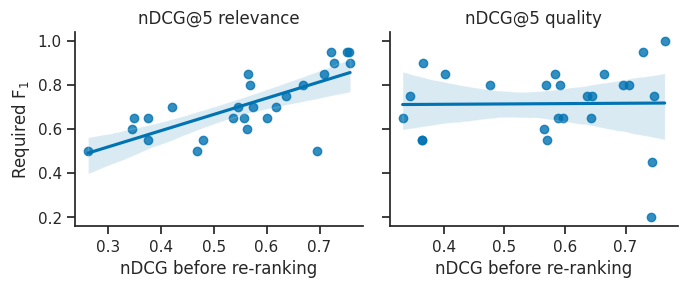